# CS5014 Machine Learning 

#### Practical 2
###### Credits: 50% of the coursework

#### Student ID: 200007413

## Aims


The objectives of this assignment are:

* deepen your understanding of probabilistic generative models
* deepen your understanding of the EM algorithm
* gain experience in implementing generative AI models with latent variables

## Set-up

You are **only allowed** to use the following imported packages for this practical. 

In [4]:
# if you use jupyter-lab, switch to %matplotlib inline instead
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

In [5]:
# use fixed random number generator seed 
random_seed = 123
rng = np.random.default_rng(random_seed)

In addition, we are going to use some functions from `sklearn`
* to use the ordinary `K-means` as a baseline
* to evaluate clustering performance of a clustering algorithm; read further for a quick demonstration

## Question 1 (Spherical K-means)

In this question, you are going to implement a variant of K-means algorithm, which is called *Spherical K-means*. This algorithm is a popular clustering algorithm for text data.

### The dataset & K-means baseline
The 20 Newsgourps text dataset is used for this question. The dataset comprises around 18000 posts on 20 topics. For simplicity, we are going to use documents from the following three topics
* talk, religion & misc
* computer graphics
* science & space

The documents have been transformed by `Bag of Words` followed by `Tfidf` vectorisation (more details can be found [here](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)). As a result, each document is represented by an $\mathbb{R}^{3000}$ vector, where each dimension corresponds to a word in the term dictionary. And there are in total $n=2501$ documents. The data, a matrix of size ${2501\times 3000}$ together with the corresponding encoding information, is imported for you below.
* `X_news`: a $2501 \times 3000$ document-term matrix to cluster
* `news_labels`: a $2501\times 1$ vector encoding the true topic/cluster of the documents
* `news_terms`: a $3000\times 1$ vector of the terms (`string` typed)

In [6]:
# read in X_news data 
X_npz = sparse.load_npz('./datasets/newsdata.npz')
X_news = X_npz.toarray()
# read in the associated TfIdf encoding information
news_labels = np.squeeze(np.array(pd.read_csv('./datasets/newsdata_labels.csv', header=None), dtype=int))
news_terms = np.squeeze(np.array(pd.read_csv('./datasets/newsdata_terms.csv', header=None)))

#### Apply `Kmeans` & clustering evaluation

We aim to cluster the documents unsupervisedly. Such a task is known as "topic modelling" in NLP. Ideally, we want those similar themed documents being clustered together to form a "topic".

The code below demonstrates  
* apply `Kmeans` from `sklearn` to cluster the documents
* and evaluate the clustering performance by adjusted rand index & V-measure

In [7]:
km_rst = KMeans(n_clusters=3, max_iter=100, n_init=5, random_state=234).fit(X_news)

In [8]:
km_ridx = metrics.adjusted_rand_score(news_labels, km_rst.labels_)
km_vm = metrics.v_measure_score(news_labels, km_rst.labels_)
print("Adjusted rand index (Kmeans): ", f"{km_ridx: .5f}")
print("V-measure (Kmeans): ", f"{km_vm: .5f}")

Adjusted rand index (Kmeans):  -0.00051
V-measure (Kmeans):   0.00587


We evaluate the `Kmeans` clustering by using the adjusted rand index & V-measure
* the adjusted rand index (ranging from $-0.5$ to $1$; higher is better) is  -0.00051
* and V-measure (ranging from $0$ and $1$; higher is better) is 0.00587
* both indicate that `Kmeans` performs really bad; in particular, a negative adjusted rand index indicates the clustering is worse than random guess

#### The mined "topics"
We can also discover the "topics" from the clustering result. That is, for each of the cluster center $\boldsymbol{\mu}_k \in \mathbb{R}^{3000}$, we find the top $T$, say $T=15$, most popular terms.

In [9]:
def print_topics(terms, us, T=15):
    for i in range(3):
        print(f"Cluster {i}: ", end="")
        for ind in (-us[i, :]).argsort()[:T]:
            print(f"{terms[ind]} ", end="")
        print()

print_topics(news_terms, km_rst.cluster_centers_, 15)

Cluster 0: edu image pub graphics data ftp 128 available lord package mail software images processing 3d 
Cluster 1: space like god people just don nasa know time think image earth does use program 
Cluster 2: jpeg gif image file color format quality images jfif version free files programs bit quicktime 


`Kmeans` failed to group the documents in a clean and meaningful way (recall the three topics are religion, science-space and computer graphics)
* it seems `cluster 0` is a mixture of both graphics and religion
* and the rest are all a bit mixed; 

### Spherical K-means

Your task is to implement a variant of K-means algorithm, which is called *Spherical K-means*. The algorithm is listed below.



**Initialisation step**: Start with randomly selecting $K$ data points as the centroids. 

**Assignment step**: *Spherical K-means* assigns a data point to the closest centroid based on *cosine distance* rather than Euclidean distance; specifically, for $i=1,\ldots, n$

$$z^{(i)} \leftarrow \arg\min_{k} \left (1- \frac{\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_k\| \cdot \|\mathbf{x}^{(i)}\|}\right ),$$

* where $\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} = \sum_{j=1}^d {\mu}_{kj} \cdot {x}^{(i)}_{j}$ denotes the inner product and $\|\mathbf{x}\|$ is $L_2$ norm of a vector $\mathbf{x}$: $\|\mathbf{x}\| = \sqrt{\mathbf{x}^\top \mathbf{x}}$.

**Update step**: *Spherical K-means* updates the centroids such that they are unit one vectors; for $k=1,\ldots, K$

$$\boldsymbol{\mu}_k \leftarrow \frac{\sum_{i=1}^n \mathbb{1}(z^{(i)} =k) \cdot  \mathbf{x}^{(i)}}{\|\sum_{i=1}^n \mathbb{1}(z^{(i)} =k) \cdot \mathbf{x}^{(i)}\|}.$$ 

* Note that after the normalisation step, the centroids $\boldsymbol{\mu}_k$ are norm-one vectors: i.e. $\|\boldsymbol{\mu}_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps **until** the total cosine distance loss converges, where the loss is defined as

$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\boldsymbol{\mu}_{z^{(i)}}^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_{z^{(i)}}\| \cdot \|\mathbf{x}^{(i)}\|}\right ).$$



### Task 1.1 Implementation of Spherical K-means

Implement the `sphericalKmeans` algorithm. The method `sphericalKmeans` has

**Inputs**:
* `data`: a $n\times d$ matrix to cluster, i.e. each row of $\texttt{data}$ is one observation $\mathbf{x}^{(i)}$
* `K`: the number of the clusters
* `tol`: tolerence of error, which is used to check whether the loss has converged so the iteration can stop
* `maxIters`: the maximum number of iterations that is allowed

**Outputs**:

* `losses`: the whole trajectory of losses over the iterations
* `zs`: the clustering labels
* `us`: the learnt $K$ centroids

**Hint**: 
* write helper methods such as `assign_step` and `update_step`; 
* do plenty of unit tests whenever you finish implementing one method
* start with something simple and correct then refine it iteratively (to improve efficiency & vectorisation);
* vectorise your code (use `numpy` as much as possible). If you use Python, you **should avoid writing plain loops at all cost** *i.e.* to iterate observations one-by-one individually; Julia's loop is very fast but vectorisation should be adopted to make it even faster
  * as an extra hint, part of the update step can be implemented as matrix matrix multiplication if you zero-hot encode the assignment vector `zs` 

* efficiency is not the most important concern, but it does matter; consider caching computed results rather than recomputing them in a loop over and over again


In [10]:
def assign_step(data, us, K):
    n, d = data.shape
    Z = np.zeros((n, K))
    for k in range(K):
        Z[:, k] = 1 - ((np.dot(us[k],data.T)) / (np.dot(np.linalg.norm(us[k]), np.linalg.norm(data))))
    return Z, np.argmin(Z, axis=1)

def update_step(data, zs, K):
    n, d = data.shape
    us = np.zeros((K, d))
    for k in range(K):
        us[k] = np.mean(data[zs == k], axis=0)
    return us

def calculate_loss(data, us, zs):
    n, d = data.shape
    loss = np.zeros(n)
    for i in range(n):
        loss[i] = 1 - ((np.dot(us[zs[i]],data[i])) / (np.dot(np.linalg.norm(us[zs[i]]), np.linalg.norm(data[i]))))
    return loss.sum()
    
def sphericalKmeans(data, K=3, tol= 1e-4, maxIters= 100):
    n, d = data.shape
    losses = []
    # initialisation: randomly assign K observations as centroids
    # feel free to use a different but sensible initialisation method    
    init_us_ids = rng.integers(n, size = K)
    us = data[init_us_ids, :]
    Z = np.zeros((n, K))
    zs = np.zeros(n, dtype=int)
    losses.append(calculate_loss(data, us, zs))
    # loop until converge 
    for i in range(maxIters):
        # assignment step
        Z, zs = assign_step(data, us, K)

        # update step
        us = update_step(data, zs, K)

        # convergence check   
        losses.append(calculate_loss(data, us, zs))

        if len(losses) > 1 and abs(losses[-2] - losses[-1]) < tol:
            break
    return losses, us, zs


### Task 1.2 Evaluation

Run the algorithm on the news dataset `X_news` with $K =3$. Note that like K-means, Spherical K-means also suffers from bad initialisations. To deal with that, we can run the algorithm multiple times with different random initialisations. To make your life easier, you may want to write a wrapper method that does it automatically.

Please report the following information based on your results 
* the final loss and also plot the loss trajectory
* the corresponding adjusted rand index and V-measure
* the top 15 terms of each of the three centroids

If you run multiple times, you only need to report the results for the best one.

In [11]:
def testSphericalMeans(data, R):
    losses, us, zs = sphericalKmeans(data)
    ridx = metrics.adjusted_rand_score(news_labels, zs)
    vm = metrics.v_measure_score(news_labels, zs)
    best = vm + ((ridx + 0.5) / 1.5)
    for i in range(R-1):
        tmp_losses, tmp_us, tmp_zs = sphericalKmeans(data)
        tmp_ridx = metrics.adjusted_rand_score(news_labels, tmp_zs)
        tmp_vm = metrics.v_measure_score(news_labels, tmp_zs)
        score = tmp_vm + ((tmp_ridx + 0.5) / 1.5)
        if (score > best):
            losses = tmp_losses
            us = tmp_us
            zs = tmp_zs
            vm = tmp_vm
            ridx = tmp_ridx
            best = score
    return losses, us, zs, ridx, vm

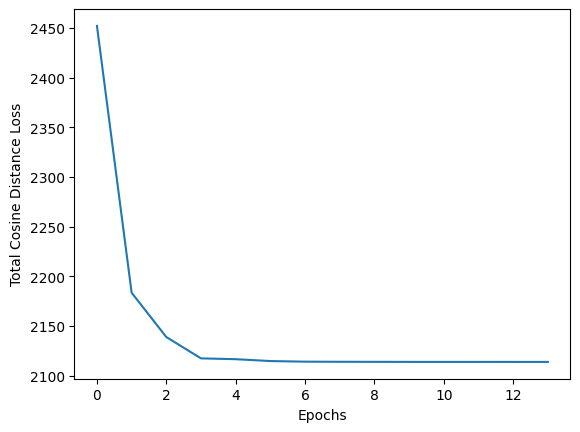

Final Loss:   2113.81042
Adjusted rand index (Spherical Kmeans):   0.46497
V-measure (Spherical Kmeans):   0.45876
Cluster 0: space launch nasa earth orbit shuttle spacecraft solar mission satellite moon lunar venus mars larson 
Cluster 1: god jesus people don bible think just say lord christian christ like know did said 
Cluster 2: image jpeg graphics edu file images ftp gif data pub software format available files color 


In [12]:
losses, us, zs, ridx, vm = testSphericalMeans(X_news, 3)

plt.plot(losses, label = 'Training loss')
plt.xlabel("Epochs")
plt.ylabel("Total Cosine Distance Loss")
plt.show()

print("Final Loss: ", f"{losses[-1]: .5f}")
print("Adjusted rand index (Spherical Kmeans): ", f"{ridx: .5f}")
print("V-measure (Spherical Kmeans): ", f"{vm: .5f}")

print_topics(news_terms, us, 15)
 


### Task 1.3 Conceptual question


##### Compare the performance against K-means', what do you observe? 




*__Answer__*:

In [13]:
print("=== Rand Index")

print("KMeans Adjusted rand index (Kmeans): ", f"{km_ridx: .5f}")
print("Spherical KMeans Adjusted rand index (Kmeans): ", f"{ridx: .5f}")

print("=== V-Measure")

print("KMeans V-measure (Kmeans): ", f"{km_vm: .5f}")
print("Spherical KMeans V-measure (Kmeans): ", f"{vm: .5f}")

=== Rand Index
KMeans Adjusted rand index (Kmeans):  -0.00051
Spherical KMeans Adjusted rand index (Kmeans):   0.46497
=== V-Measure
KMeans V-measure (Kmeans):   0.00587
Spherical KMeans V-measure (Kmeans):   0.45876


Given the v-measure and rand-index performance metrics. The spherical k-means is much more successful than the standard k-means algorithm at categorizing terms (several orders of magnitude more so).

In addition, subjectively the term categories seem to be more specific. Cluster 0 being computer graphics, cluster 1 being religion, and cluster 2 being astronomy.


##### If Spherical Kmeans performs better, what might be the reason? 
* Hint: compare cosine distance vs Euclidean distance; what happen if the data's dimension is large?

*__Answer__*:

The difference between the two algorithms is in the optimisation function for the cluster centers. Standard k-means minimises euclidian distance (the distance between two points), whereas spherical k-means uses cosine distance (angle distance between two points).

For text analysis higher numbers of dimensions is useful as there are many categories of text and we want to make sure we seprate them accurately (to prevent the mixed categoires as shown in the question preamble). Euclidian distance is less effective at higher dimensionality because the distance between points becomes relatively equal when averaged over all dimensions. Angles aren't affected in the same way.

## Question 2 (EM algorithm)



In this question, we are going to implement an EM algorithm for finite mixture of Bernoullis which can be used to cluster binary valued images and also generate or complete partial images (the extension part). And, yes, it is called generative AI nowadays. 

The following writeup looks pretty long, but it only covers the necessary background. The algorithm is fairly simple and has been derived for you. And the implementation typically requires less than 10-15 lines of code. You may skip to the pseudo code and implement the algorithm directly. But remember a solid understanding of the underlying maths is essential when it comes to implementing ML algorithms. 




### Overview

We are going to use a modified MNIST handwritten digit dataset. The images are essentially $28 \times 28$ binary matricies, *i.e.* the pixels take values in $\{0, 1\}$. The spatial structure of the images is ignored, so each image/matrix is collapsed to a $784$-dimensional binary vector: $\mathbf{x} \in \{0,1\}^{784}$. 

The required dataset is imported below. In particular,
* `X_mnist_train`: a $4000 \times 784$ binary matrix, where each row is one image and there are 4000 images in the training data; 
* `Y_mnist_train`: the corresponding 4000 labels of the images
* `X_mnist_test`, `Y_mnist_test`: a further $1000 \times 784$ test data and labels (required for the extension part)

In [14]:
## import MNIST dataset, it might take a while!
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

In [15]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

**Supervised learning:**
If the labels $\{z^{(i)}\}$ are known, the model parameters' estimates are simply the pooled sample means. That is: for $k=1,\ldots, K$

$$\boldsymbol{\mu}_k = \frac{1}{n_k} \sum_{i=1}^n \mathbb{1}(z^{(i)} =k)\mathbf{x}^{(i)}$$

* where $n_k = \sum_{i=1}^n \mathbb{1}(z^{(i)} =k)$ is the number of images belong to the $k$-th class.
* note that each $0\leq \mu_{kd} \leq 1$ indicates how bright a pixel at location $d$ should be (or how likely that pixel is a $1$) assuming it is digit $k$.

In [16]:
μs_sup = np.zeros((10, 784))
for k in range(10):
    μs_sup[k, :] = np.mean(X_mnist_train[Y_mnist_train == k, :] , axis=0)

And the learnt centers $\{\boldsymbol{\mu}_k\}$ are plotted below. They look pretty nice and clean.

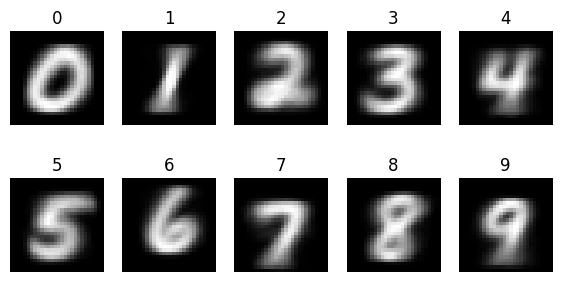

In [17]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = μs_sup[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show();

Next, we are going to solve the problem **unsupervisedly**, *i.e.* do the clustering without knowing the labels $\{z^{(i)}\}$. To do it, we need a proper probabilistic generative model.

### Finite mixture of Bernoullis
_(You can skip this section if you are already familiar with the model)_

A finite mixture of Bernoullis (called `MixBern` hereafter) is very similar to other mixture models we have seen in the lecture. Compared with mixture of Gaussian, the only change is that we assume the component's likelihood is a collection of independent Bernoulli random variables. To be more specific, conditioned on the hidden cluster label $z^{(i)} =k$, each pixel, $x_d^{(i)} \in \{0, 1\}$, is an independent Bernoulli random variable (or coin tossing if you prefer) with a bias $\mu_{kd}$ ($0\leq \mu_{kd} \leq 1$): 

$$\begin{align} p(\mathbf{x}^{(i)}| z^{(i)}=k, \{\boldsymbol{\mu}_k\}_{k=1}^K) &= \prod_{d=1}^D p(x_d^{(i)} | z^{(i)}=k, \boldsymbol{\mu}_k) \\
&=\prod_{d=1}^D \mu_{kd}^{x^{(i)}_{d}} \cdot (1-\mu_{kd})^{1-x^{(i)}_d},
\end{align}$$

* where we have used the conditional independence assumption in the first equation then sub-in the Bernoulli's probability mass function in the second line. Make sure you understand the above formulas before moving on. 


The joint model factors as:

$$p(z^{(i)}, \mathbf{x}^{(i)}) = p(z^{(i)})p( \mathbf{x}^{(i)}|z^{(i)}),$$

* and the joint distribution encodes the following generative process: 

---
for $i=1,\ldots, n$
1. sample $z^{(i)}$ from a prior Categorical distribution with prior proportion parameter $\boldsymbol{\pi}$
$$z^{(i)} \sim \mathcal{Cat}(\boldsymbol{\pi})$$

2. For each pixel $d = 1,\ldots, D$,
    * conditioned on the sampled $z^{(i)}=k$, sample a Bernoulli variable with bias $\mu_{kd}$
$$x^{(i)}_d \sim \mathcal{Ber}(\mu_{kd})$$

----


The **observed or marginal likelihood**, due to the sum rule, is 

$$p(\mathbf{x}^{(i)}|\boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}) = \sum_{k=1}^K p(z^{(i)}=k)p( \mathbf{x}^{(i)}|z^{(i)}=k) = \sum_{k=1}^K \pi_k \cdot p(\mathbf{x}^{(i)}| \boldsymbol{\mu}_k)$$

* EM aims to maximise the above w.r.t the model parameter $\boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}$ via an iterative procedure

**Summary of notations**
It is a good idea to summarise the notations we have used so far

* ``n=4000``, the number of training images; the training data is indexed by $i$
* ``D = 784``, the number of pixels of each image vector $\mathbf{x}$, indexed by $d$
* ``K``, the number of mixture components, indexed by $k$

The model parameters we aim to learn are

$$\boldsymbol{\pi} = \begin{bmatrix}\pi_1, \pi_2, \ldots, \pi_K \end{bmatrix}^\top; \;\;\;\boldsymbol{\mu}s = \begin{bmatrix}\rule[.5ex]{2.5ex}{0.5pt}  & \boldsymbol{\mu}_1^\top & \rule[.5ex]{2.5ex}{0.5pt} \\
\rule[.5ex]{2.5ex}{0.5pt}  & \boldsymbol{\mu}_2^\top & \rule[.5ex]{2.5ex}{0.5pt} \\
&\vdots& \\
\rule[.5ex]{2.5ex}{0.5pt}  & \boldsymbol{\mu}_K^\top & \rule[.5ex]{2.5ex}{0.5pt} \\
\end{bmatrix}_{K\times D}$$

### Task 2.1 randomly sample from a `MixBern`

Firstly, write a method that randomly generates samples from a finite mixture of Bernoullis.  The method should have
**input** 
* `πs`: the prior mixture proportion $\pi_k$ for $k=1,\ldots, K$;
* `μs`: $K$ sets of bias parameters; or a $K\times D$ bias matrix (where $0 \leq\mu_{kd} \leq 1$)
* `n`: number of samples to generate

**output**
* `samples`: the gererated samples, should be a ``n`` by ``D`` matrix
* `zs`: the true cluster labels, where each $z_i \in 1, 2\ldots, K$ is the index of the cluster that has generated the ``i``-th sample.



In [18]:
def sample_mixberns(πs, μs, n):
	K, d = μs.shape
	## xs supposed to be binary pixels
	xs_samples = np.zeros((n, d), dtype='bool')
	# draw the true labels from a categorical distribution with parameter π
	zs = rng.choice(K, n, p=πs)
    # fill the missing steps here !
	# Hint: to draw a Bernoulli with bias say 0.8, use rng.random() < 0.8
	for i in range(n):
		value = zs[i]
		biases = μs[value]
		xs_samples[i] = np.random.rand(d) < biases
	return xs_samples, zs


Once you have done so, use the implemented method to sample `n=500` samples from a ($K=3$) MixBern with dimension size $D=9$, where the model parameters are
* $\boldsymbol{\pi} = [0.4, 0.3, 0.3]^\top$
* $\boldsymbol\mu_1 = [0.9, 0.9, 0.9, 0.1 \ldots, 0.1]^\top$; $\boldsymbol\mu_2 = [0.1, 0.1, 0.1, 0.9 , 0.9, 0.9, 0.1, 0.1, 0.1]^\top$ and $\boldsymbol\mu_3 = [0.1,  \ldots, 0.1, 0.9, 0.9, 0.9]^\top$; note that `μs` stacks the three vectors vertically to form a $3\times 9$ matrix


The simulated dataset will be very useful later on to debug your EM implementation. 

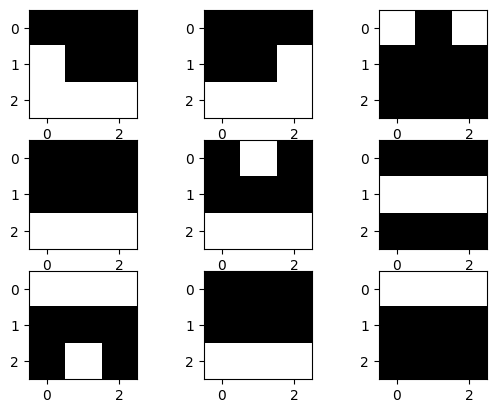

In [19]:
# to type π: type \pi + tab; \mu + tab for Θ
trueπs = np.array([0.4, 0.3, 0.3])
trueμs = 0.1 * np.ones((3, 9))
trueμs[0, 0:3] = 0.9
trueμs[1, 3:6] = 0.9
trueμs[2, 6:] = 0.9
n_size = 500
sim_X, truezs = sample_mixberns(trueπs, trueμs, n_size)

# Test: Print plot of a few samples to check intuition on biases

d_rows = 3
d_cols = 3
fig = plt.figure()
for i in range(0, d_cols*d_rows):
    ax = fig.add_subplot(d_rows, d_cols, i+1)
    ax.imshow(sim_X[i].reshape(-1, 3), interpolation="nearest", cmap="gray", aspect=1)
plt.show()

### Task 2.2 E step implementation

The E step computes the $n\times K$ responsibility matrix $\mathbf{R}$, where each entry $r_{ik} = p( z^{(i)}=k|\mathbf{x}^{(i)})$ is the posterior probability of the $i$-th observation $\mathbf{x}^{(i)}$ belongs to the $k$-th cluster. Based on Bayes' rule, 

$$r_{ik} \propto \pi_k\cdot p(\mathbf{x}^{(i)}| z^{(i)}=k, \{\boldsymbol{\mu}_k\})$$

We usually work with probabilties in log space, the formula becomes

$$\begin{align}
\ln r_{ik} &= \ln\pi_k + \ln p(\mathbf{x}^{(i)}| z^{(i)}=k, \{\boldsymbol{\mu}_k\}) + C\\
&=\ln\pi_k + \sum_{i=1}^D x_d^{(i)} \ln\mu_{kd} + (1-x_d^{(i)}) \ln(1-\mu_{kd}) + C
\end{align}$$

* make sure the above derivation makes sense to you

Now implement the above E-step
* `input`: the $n\times D$ data matrix $\mathbf{X}$, model parameter $\boldsymbol{\pi}$ and $\boldsymbol{\mu}s$

* `output`: the responsibility matrix and also the average marginal log likelihood: 

$$\ell(\boldsymbol{\pi}, \boldsymbol{\mu}s)=\frac{1}{n}\ln p(\{\mathbf{x}^{(i)}\}_{i=1}^n|\boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}) = \frac{1}{n} \sum_{i=1}^n\ln\left \{ \sum_{k=1}^K \pi_k \cdot p(\mathbf{x}^{(i)}| \boldsymbol{\mu}_k)\right \}$$

## Hints


* It is a good idea to implement the log likelihood for the indepenet Bernoulli model first. i.e. 

    ```python
    def logpdf(X, μk):
    	...
    ```
  where it implements the following log-likelihood

$$\ln p(\mathbf{x}^{(i)}| z^{(i)}=k, \boldsymbol{\mu}s)= \sum_{i=1}^D\left(x_d^{(i)} \ln\mu_{kd} + (1-x_d^{(i)}) \ln(1-\mu_{kd})\right)$$

* Note that it is just sum of $D$ (negative) cross-entropy losses!
* It is a good idea to `np.clip` $\mu$ (and $1-\mu$ ) with a lower bound `np.finfo(float).eps` so $\ln (\mu)$ does not return -Inf: check the difference between `np.log(0)` and `np.log(eps(Float64))`


* Debug your E-step with the simulated dataset. You should use the true π and true μ; if your E-step is correctly implemented, the returned responsibility matrix should match the true `zs` well.

In [20]:
def logpdf(X, μk):
    return np.sum(X[:, None, :] * np.log(np.clip(μk, np.finfo(float).eps, None)) + (1 - X[:, None, :]) * np.log(np.clip(1 - μk, np.finfo(float).eps, None)), axis=2)

def e_step(X, πs, μs):
    n, d = X.shape
    K = len(πs)

    # Log Likelihoods
    logLik = np.log(np.clip(πs, np.finfo(float).eps, None)) + logpdf(X, μs)

    # Responsibilities
    R = np.exp(logLik)
    
    # Normalize
    R /= R.sum(axis=1, keepdims=True)

    logLik = np.mean(np.log(np.exp(logLik).sum(axis=1)))    
    
    return R, logLik

In [21]:
R, loglik = e_step(sim_X, trueπs, trueμs)
print(R, loglik)
print("Agreement with truezs:", (R.argmax(axis=1) == truezs).sum() / R.shape[0])

[[2.50851327e-06 1.52392181e-04 9.99845099e-01]
 [2.50851327e-06 1.52392181e-04 9.99845099e-01]
 [9.99771429e-01 1.14285714e-04 1.14285714e-04]
 ...
 [2.50889088e-06 1.88166816e-06 9.99995609e-01]
 [2.50889088e-06 1.88166816e-06 9.99995609e-01]
 [9.90713477e-01 1.13250283e-04 9.17327293e-03]] -3.9886143283484743
Agreement with truezs: 0.982


### Task 2.3 M step implementation

The M step re-estimates the model parameter based on $\mathbf{R}$. Luckily, the re-estimation is exactly the same as EM for Gaussian mixture. In other words, the weighted MLE estimator for $\boldsymbol{\mu}_k$ are just the weighted sample average.

---
For $k=1, \ldots, K$:

$$\pi_k = \frac{n_k}{n};\;\; \boldsymbol{\mu}_k = \frac{\sum_{i=1}^n r_{ik} \cdot \mathbf{x}^{(i)}}{n_k},$$


* where $n_k = \sum_{i=1}^n r_{ik}$
---

Now implement the above M-step 
* `input`: the $n\times D$ data matrix and responsibility matrix

* `output`: the reestimated parameters $\boldsymbol{\pi}$ and $\boldsymbol{\mu}s$



In [22]:
def m_step(X, R):
    n, d = X.shape
    K = R.shape[1]

    # Compute πs
    Nk = R.sum(axis=0)
    πs = Nk / n

    # Compute μs
    μs = (R.T @ X) / Nk[:, None]

    return πs, μs

In [23]:
πs, μs = m_step(sim_X, R)
print(πs)
print(μs)

[0.39525641 0.28460996 0.32013363]
[[0.90363208 0.8602437  0.91214558 0.11030396 0.08141756 0.09504369
  0.10422944 0.10487373 0.09308539]
 [0.07385527 0.08862131 0.10393215 0.93243921 0.91256276 0.87686647
  0.10254624 0.15147122 0.08836152]
 [0.06813929 0.08359214 0.08711514 0.10939235 0.06901724 0.1089184
  0.84844871 0.8853733  0.88731332]]


### Task 2.4 EM algorithm for MixBerns

Implement an EM algorithm that can learn the parameters of finite mixture of Bernoullis. A simple initialisation strategy is to randomly assign each observation to one of the $K$ cluster (initialise with a E step) then find the corresponding $\boldsymbol{\mu}s$. Feel free to try other initialisations. 

The method takes similar input as `sphericalKmeans` but it should output
* `logLiks`: the trajectory of the (log)-likelihood
* `πs, μs`: the learnt parameters of the finite mixture model
* `R` and `zs`: the responsibility matrix and the assigned clusters of the observations


In [24]:
def em_mixberns(X, K, tol = 1e-4, maxIters = 100):
	## initilisation
	n, d = X.shape
	logLiks = []

	πs = np.zeros(K)
	μs = np.zeros((K, d))
	
	R = np.random.rand(n, K)
	R /= R.sum(axis=1)[:, None]
	
	πs, μs = m_step(X, R)

	## E-M loop
	## repeat until converge
	for i in range(maxIters):
	  ## E step
		R, logLik = e_step(X, πs, μs)
	  ## M step
		πs, μs = m_step(X, R)
		logLiks.append(logLik)
		if (len(logLiks) > 1 and abs(logLiks[-2] - logLiks[-1]) < tol):
			break;
	return logLiks, πs, μs, R.argmax(axis=1), R

#### Evaluate on the simulated dataset

Run your EM algorithm on the dataset simulated in Task 2.1. 
You may need to repeat the algorithm a few times with different random initialisations to avoid bad initialisations. You need to show:
* whether your algorithm can recover the true parameters when correct $K=3$ is given ? 
* plot the (log)Likelihood trajectory

Report your results below.

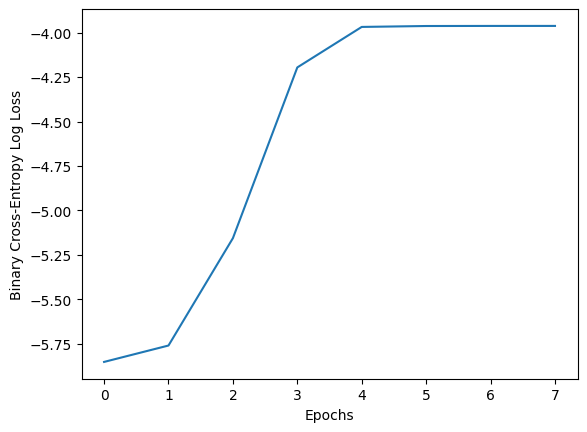

[0.28154084 0.39659837 0.32186079]
[0.4 0.3 0.3]
[[0.07202994 0.09060461 0.09841422 0.93764147 0.9254117  0.87868026
  0.10478896 0.15655549 0.08422865]
 [0.90291001 0.85616525 0.91374183 0.1130311  0.08137224 0.09796183
  0.10410367 0.10488747 0.09163591]
 [0.06719671 0.08369256 0.08669542 0.10932578 0.06582572 0.11111673
  0.84263226 0.87716506 0.88840751]]
[[0.9 0.9 0.9 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.9 0.9 0.9 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.9 0.9 0.9]]
Agreement with truezs: 0.318


In [25]:
logLiks, πs, μs, zs, R = em_mixberns(sim_X, 3);

plt.plot(logLiks, label = 'Sample loss')
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Log Loss")
plt.show()

print(πs)
print(trueπs)

print(μs)
print(trueμs)


# print("--- ZS ---")
# print(zs)
# print(truezs)

print("Agreement with truezs:", (zs == truezs).sum() / zs.shape[0])

This algorithm can recover the correct parameters to a reasonable degree of error with $K=3$, but it is uncommon given the initializatin. Often $1-$ the real value are found. Therefore, this value would only be appropriate on a supervised training set with known labels to check against.


#### Evaluate on MNIST
Run your EM algorithm on the MNIST dataset with $K=10$ and report the following

* plot the log likelihood trajectory

* report the adjusted rand index 

* plot the $K$ centers found by the EM algorithm (*i.e.* each row of $\boldsymbol{\mu}s$) as 28 by 28 pixeled images


In [26]:
K = 10
REPEATS = 2

logLiks, πs, μs, zs, R = em_mixberns(X_mnist_train, K);
maxLogLik = logLiks[-1]

for i in range(REPEATS-1):
  tmp_logLiks, tmp_πs, tmp_μs, tmp_zs, tmp_R = em_mixberns(X_mnist_train, K);
  if (tmp_logLiks[-1] > maxLogLik):
    logLiks = tmp_logLiks
    maxLogLoss = logLiks[-1]
    πs = tmp_πs
    μs = tmp_μs
    zs = tmp_zs
    R = tmp_R
  
em_mixberns_mnist_ridx = metrics.adjusted_rand_score(Y_mnist_train, zs)


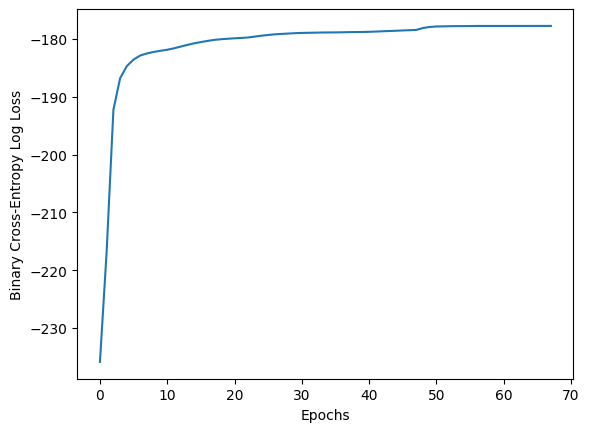

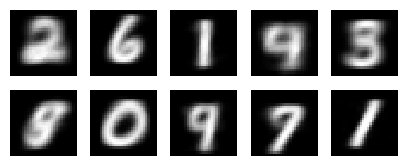

Rand Index:
0.36698835436765287


In [27]:
plt.plot(logLiks, label = 'MNIST Train loss')
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Log Loss")
plt.show()

d_rows = 5
d_cols = 5
k = πs.shape[0]
fig = plt.figure(figsize=(d_rows, d_cols))
for i in range(k):
    ax = fig.add_subplot(d_rows, d_cols, i+1)
    ax.imshow(μs[i].reshape(-1, 28), interpolation="nearest", cmap="gray", aspect=1)
    ax.axis("off")
plt.show()

print("Rand Index:")
print(em_mixberns_mnist_ridx)


### Task 2.5* Image generation (Extension)

Probabilistic generative models such as MixBerns can be used to generate new images.  It is because the model comprises distributions for both the hidden label $z$ and also the feature data $\mathbf{x}$. 

Now consider the following problem. You are given partially observed images (*e.g.* images on the left-hand side) and want to complete the images. The original images are listed in the middle column. The completed images (on the right-hand side) are generated by a learnt MixBern model (with $K=15$). Although MixBern's model is very basic and not "deep" in any sense, it does a decent job at generating hand-written images at least. 

![p1](https://leo.host.cs.st-andrews.ac.uk/CS5014/P2/mnist_cover.png)
![p2](https://leo.host.cs.st-andrews.ac.uk/CS5014/P2/mnist_origin.png)
![p3](https://leo.host.cs.st-andrews.ac.uk/CS5014/P2/mnist_impute.png)




![p1](https://leo.host.cs.st-andrews.ac.uk/CS5014/P2/mnist_cover2.png)
![p2](https://leo.host.cs.st-andrews.ac.uk/CS5014/P2/mnist_origin.png)
![p3](https://leo.host.cs.st-andrews.ac.uk/CS5014/P2/mnist_impute2.png)

#### Posterior predictive distribution
The benefit of adopting a formal probabilistic approach is that all ML problems uniformly translate to formal probabilistic inferences. And the results emerge naturally.

To be more specific, one only needs to implement a posterior predictive distribution for the missing data. Denote the observed pixel index set as $\mathcal{O}$, and the missing/hidden pixel index set as $\mathcal{H}$. Note that $\mathcal{O} \cup\mathcal{H} = \{1,2,\ldots, 784\}$. The posterior predictive distribution is defined as 


$$p(\mathbf{x}_{\mathcal{H}}=\mathbf{1}|\mathbf{x}_{\mathcal{O}}, \boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}) = \sum_{k=1}^K p(\mathbf{x}_{\mathcal{H}}=\mathbf{1} |z=k,  \boldsymbol{\mu}_k) p(z =k|\mathbf{x}_{\mathcal{O}})$$

* where $\mathbf{x}_\mathcal{O}$ denotes the observed sub-vector and $\mathbf{x}_\mathcal{H}$ is the missing/hidden part

* the above distribution is a weighted average of $K$ predictions and each predictions are simply

$$p(\mathbf{x}_{\mathcal{H}} =\mathbf{1} |z=k,  \boldsymbol{\mu}_k) = \boldsymbol{\mu}_{k,\mathcal{H}}$$
 
* and we can show the posterior is almost the same as before, but simply ignore the missing pixels

$$p(z =k|\mathbf{x}_{\mathcal{O}}) \propto \pi_k \prod_{d \in \mathcal{O}} p(x_d|z=k, \boldsymbol{\mu}_k)$$

#### Task 2.5.1 Conceptual question
* show that the above posterior predictive distributions are correct based on the generative model and probability rules.



***Answer:***

TODO: Show posterior pred dist are correct based on gen model and prob rules

#### Task 2.5.2 Implementation 

(I strongly encourage you to attempt this extension. It only requires less than 3-4 additional lines of code.) 

* Replicate the above result by implementing `posterior_predictive_impute(...)`
  * `input`: a vector with missing data and learnt model parameter $\boldsymbol{\pi}$ and $\boldsymbol{\mu}s$
  * `output`: an imputed vector where the missing parts are inputed with the posterior mean


Hint: just change the `E-step` first (to incorporate the missing data, ignore the missing pixels) then compute a weighted average)

In [28]:
## generate images with missing pixels for the top half
X_mnist_cover1 = np.empty_like(X_mnist_test, dtype='f')
X_mnist_cover1[:] = X_mnist_test
# setting the top half pixels to nan/missing
X_mnist_cover1[:, 0: int(784//2)] = np.nan
## try other ways to cover the images!

In [29]:
def dlogpdf(x, μk):
    return (x * np.log(np.clip(μk, np.finfo(float).eps, None)) + ((1 - x) * np.log(np.clip(1 - μk, np.finfo(float).eps, None)))).sum(axis=1)

def posterior_predictive_impute(x, πs, μs):
    # Find the missing idx/observed idx set of x
    missing_idx = np.isnan(x)
    observed_idx = ~missing_idx

    # Compute likelihood for each cluster
    logLiks = dlogpdf(x[observed_idx], μs[:, observed_idx])

    posteriors = np.exp(np.log(πs) + logLiks)

    # Normalize
    posteriors /= posteriors.sum(axis=0)

    # Compute predictive mean for missing values
    pred_x_missing = np.dot(posteriors, μs[:, missing_idx])


    # Add back the observed pixels to the predictive mean
    pred_x = np.copy(x)
    pred_x[missing_idx] = pred_x_missing

    return pred_x

In [30]:
K = 15
REPEATS = 2

logLiks, πs, μs, zs, R = em_mixberns(X_mnist_train, K);
maxLogLik = logLiks[-1]

for i in range(REPEATS-1):
  tmp_logLiks, tmp_πs, tmp_μs, tmp_zs, tmp_R = em_mixberns(X_mnist_train, K);
  if (tmp_logLiks[-1] > maxLogLik):
    logLiks = tmp_logLiks
    maxLogLoss = logLiks[-1]
    πs = tmp_πs
    μs = tmp_μs
    zs = tmp_zs
    R = tmp_R

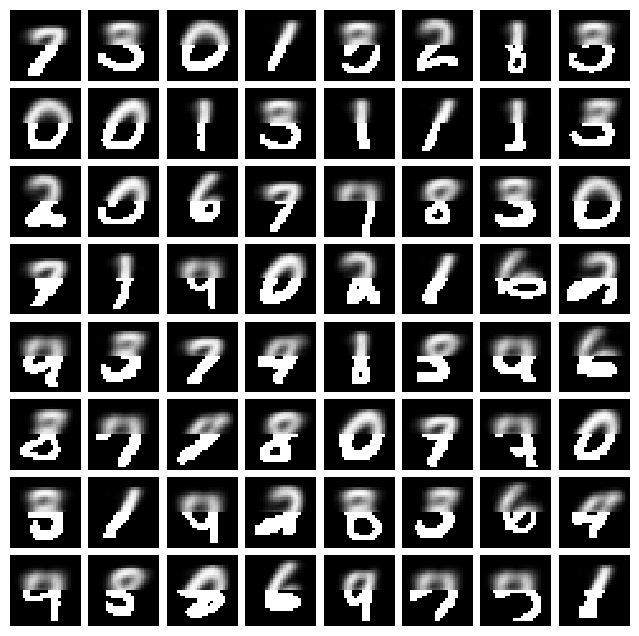

In [31]:
d_rows = 8
d_cols = 8
k = πs.shape[0]
fig = plt.figure(figsize=(d_rows,d_cols))
for i in range(d_rows * d_cols):
    pred = posterior_predictive_impute(X_mnist_cover1[i], πs, μs)
    ax = fig.add_subplot(d_rows, d_cols, i+1)
    ax.imshow(pred.reshape(-1, 28), interpolation="nearest", cmap="gray", aspect=1)
    ax.axis("off")
    ax.set_aspect("equal")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Submission
Hand in via MMS: the completed jupyter notebook. Your notebook should be reproducible. 



## Marking
Your submission will be marked as a whole. 

* to get a grade up to 13, you are expected to complete Question 1 to a good standard
* to get a grade above 13 and up to 15, you are expected to complete all tasks except 2.4 and 2.5 to a good standard
* to achieve a grade of 16-18, you are expected to finish all tasks except Task 2.5 flawlessly 
* to get a mark above 18, you are expected to make a reasonable attempt on either part of the extension


Marking is according to the standard mark descriptors published in the Student Handbook at:

https://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#GeneralMarkDescriptors


You must reference any external sources used. Guidelines for good academic practice are outlined in the student handbook at https://info.cs.st-andrews.ac.uk/student-handbook/academic/gap.html